# Annotator Analysis for TREC Deep Learning Queries

This notebook provides a simple data ingestion pipeline from which further analysis can be derived as a group

## Data Ingestion

In [1]:
from ir_measures import read_trec_qrels
import ir_datasets as irds
import pandas as pd
import os
import pyterrier as pt
if not pt.started():
    pt.init()

PyTerrier 0.10.0 has loaded Terrier 5.10 (built by craigm on 2024-08-22 17:33) and terrier-helper 0.0.8



In [2]:
DIR = '../..' # if this breaks replace with a full path to the repo

DATASET = "msmarco-passage/trec-dl-2019/judged"
qrel_directory = f'{DIR}/judgments/main/qrels/'
annotation_directory = f'{DIR}/judgments/main/doccano/'

In [3]:

dataset = irds.load(DATASET)
original_qrels = pd.DataFrame(dataset.qrels_iter())


In [4]:
all_qrels = []
for file in os.listdir(qrel_directory):
    print(file)
    if file.endswith('.txt'):
        qrels = pd.DataFrame(read_trec_qrels(qrel_directory + file))
        annotator = file.replace('.txt', '').replace('-qrels', '')
        qrels['annotator'] = annotator
        all_qrels.append(qrels)

all_qrels = pd.concat(all_qrels)

andrew-parry-qrels.txt
ferdinand-schlatt-qrels.txt
froebe-qrels.txt
guglielmo-faggioli-qrels.txt
harry-scells-qrels.txt
saber-zerhoudi-qrels.txt
sean-macavaney-qrels.txt
eugene-yang-qrels.txt


In [5]:
all_qrels

,query_id,doc_id,relevance,iteration,annotator
0,855410,8651770,2,0,andrew-parry
1,855410,8651771,2,0,andrew-parry
2,855410,8651772,1,0,andrew-parry
3,855410,8651775,3,0,andrew-parry
4,146187,1230566,1,0,andrew-parry
...,...,...,...,...,...
1110,1114646,3915244,0,0,eugene-yang
1111,168216,4713638,0,0,eugene-yang
1112,168216,1696466,0,0,eugene-yang
1113,168216,4245224,0,0,eugene-yang


In [6]:
# for each query, doc pair take the max relevance score
max_qrels = all_qrels.groupby(['query_id', 'doc_id']).agg({'relevance': 'max'}).reset_index()
min_qrels = all_qrels.groupby(['query_id', 'doc_id']).agg({'relevance': 'min'}).reset_index()

In [7]:
max_qrels

,query_id,doc_id,relevance
0,1037798,184064,0
1,1037798,2157456,0
2,1037798,2970896,0
3,1037798,3167284,2
4,1037798,3387556,2
...,...,...,...
4506,962179,6898290,0
4507,962179,6980697,2
4508,962179,8785367,1
4509,962179,8785370,0


In [8]:
original_qrels

,query_id,doc_id,relevance,iteration
0,19335,1017759,0,Q0
1,19335,1082489,0,Q0
2,19335,109063,0,Q0
3,19335,1160863,0,Q0
4,19335,1160871,0,Q0
...,...,...,...,...
9255,1133167,8839920,2,Q0
9256,1133167,8839922,2,Q0
9257,1133167,944810,0,Q0
9258,1133167,949411,0,Q0


In [9]:
# join the original qrels with the max qrels on query_id and doc_id to compare relevance values
joined = original_qrels.merge(max_qrels, on=['query_id', 'doc_id'], suffixes=('_original', '_max'))

In [10]:
joined

,query_id,doc_id,relevance_original,iteration,relevance_max
0,19335,1231807,0,Q0,0
1,19335,1720389,1,Q0,0
2,19335,1720395,1,Q0,0
3,19335,1729,2,Q0,0
4,19335,1837110,0,Q0,0
...,...,...,...,...,...
4506,1133167,8804478,1,Q0,2
4507,1133167,8839919,1,Q0,0
4508,1133167,8839920,2,Q0,1
4509,1133167,8839922,2,Q0,3


In [11]:
all_comments = []
for file in os.listdir(annotation_directory):
    if file.endswith('.jsonl'):
        comments = pd.read_json(annotation_directory + file, lines=True)
        annotator = file.replace('.jsonl', '')
        comments['annotator'] = annotator
        # filter in case that comments 'Comments' column is an empty list
        comments = comments[comments['Comments'].apply(lambda x: len(x) > 0)]
        all_comments.append(comments)

all_comments = pd.concat(all_comments)[['text', 'annotator', 'label', 'Comments']]
all_comments['label'] = all_comments['label'].apply(lambda x: x[0])

In [12]:
all_comments

,text,annotator,label,Comments
0,"Gas. For hydrogen to become a liquid, you need...",froebe,Perfectly Relevant (3),[Description: What is the temperature in degre...
28,Definitions for Contour plowing. Here are all ...,froebe,Not Relevant (0),[A user is in a discussion about farming pract...
74,The sides AC and BD above are called the legs ...,froebe,Not Relevant (0),[Description:\nI have trapezoid in front of me...
130,Pseudobulbar palsy is characterized by the ina...,froebe,Not Relevant (0),[Description:\nI know that dysarthria can be c...
205,Left Ventricular Hypertrophy. Left Ventricular...,froebe,Not Relevant (0),[Description:\nWhat factors can contribute to ...
288,You might be interested to know that both the ...,froebe,Relevant (1),[Description:\nI am a nurse and already hold m...
389,Genera such as Rhynia have a similar life-cycl...,froebe,Not Relevant (0),[Description: tracheids are part of which tiss...
738,"After about 2 days (range 2-21 days), dependin...",froebe,Not Relevant (0),[Description:\nHow long is the complete life c...
1026,Deadly: A conceptual image of Legionella Pneum...,froebe,Not Relevant (0),[Description:\nI am in a discussion with a fri...
14,rösti (ˈrɜːstɪ) or rosti n (Cookery) a Swiss d...,guglielmo-faggioli,Relevant (1),"[This document, in my opinion, would be releva..."


In [13]:
#query_lookup = all_comments[['query', 'query_id']].drop_duplicates().set_index('query_id')['query'].to_dict()

In [14]:
#query_lookup

In [15]:
required = all_qrels['query_id'].unique().tolist()

## Helper Classes

In [16]:
import logging
import numpy as np 
from sklearn import metrics
from scipy.stats import ttest_ind

class TrecQrel:
    def __init__(self, filename=None, qrels_header=["query","q0","docid","rel"]):

        #TODO: support to check whether the fields match.
        if filename:
            self.read_qrel(filename, qrels_header)
        else:
            self.filename = None
            self.qrels_data = None

    def __repr__(self):
        return self.__str__()

    def __str__(self):
        if self.filename:
            return "Data from file %s" % (self.get_full_filename_path())
        else:
            return "Data file not set yet"

    def __filter_topics(self, df, topics):
        if type(topics) is list:
            topics = set(topics)
        if type(topics) is not set:
            print("ERROR: topics should be a set")
            return None
        return df[df["query"].apply(lambda x: x in topics)]

    def print_subset(self, filename, topics=None, labels=None, another_qrel=None):
        """
            Creates a new qrel with name 'filename' based on the selected topics or labels.

            A common use case is to have all documents that appear in another qrel. For that,
            use 'another_qrel' parameter.
        """

        if another_qrel is None and labels is None and topics is None:
            print("You should assign a set of labels, topics or at least input another qrel to be filtered.")
            return

        dslice = None
        if topics is not None and labels is None:
            dslice = self.qrels_data[self.qrels_data["query"].apply(lambda x: x in set(topics))]
        elif labels is not None and topics is None:
            dslice = self.qrels_data[self.qrels_data["rel"].apply(lambda x: x in set(labels))]
        elif labels is not None and topics is not None:
            dslice = self.qrels_data[(self.qrels_data["query"].apply(lambda x: x in set(topics))) &
                    (self.qrels_data["rel"].apply(lambda x: x in set(labels)))]

        if another_qrel:
            if dslice is None:
                dslice = self.qrels_data.copy()
            dslice = pd.merge(dslice, another_qrel.qrels_data, on=["query","q0","docid"])
            dslice["rel"] = dslice["rel_x"]
            del dslice["rel_y"]
            del dslice["rel_x"]

        dslice[["query", "q0", "docid", "rel"]].to_csv(filename, sep=" ", header=False, index=False)
        print("File %s writen." % (filename))

    @classmethod
    def from_dataframe(cls, df):
        """
            Create a TrecQrel object from a pandas dataframe.
        """
        t = TrecQrel()
        t.qrels_data = df.rename(columns={"query_id":"query","doc_id":"docid","relevance":"rel", 'iteration':'q0'})[["query","q0","docid","rel"]]
        return t

    def read_qrel(self, filename, qrels_header=None):
        # Replace with default argument for qrel_header
        if qrels_header is None:
            qrels_header = ["query", "q0", "docid", "rel"]

        # Set filename
        self.filename = filename

        # Read data from file
        self.qrels_data = pd.read_csv(filename, sep="\s+", names=qrels_header)

        # Enforce string type on docid column (if present)
        if "docid" in self.qrels_data:
            self.qrels_data["docid"] = self.qrels_data["docid"].astype(str)
        # Enforce string type on q0 column (if present)
        if "q0" in self.qrels_data:
            self.qrels_data["q0"] = self.qrels_data["q0"].astype(str)
        # Enforce string type on query column (if present)
        if "query" in self.qrels_data:
            self.qrels_data["query"] = self.qrels_data["query"].astype(str)

        # Removes the files that were not judged:
        self.qrels_data = self.qrels_data[self.qrels_data["rel"] >= 0]

    def compare_with(self, another_qrel, topics=None):
        """
            Compare two qrels for a given set of topics.
            Returns means and checks for statistical significant differences.
            Only compares documents that are available in both sets.
            Use 'topics' parameter if you want to filter even further.
        """
        if topics is not None:
            dslice = self.__filter_topics(self.qrels_data, topics)
            oslice = self.__filter_topics(another_qrel.qrels_data, topics)
        else:
            dslice = self.qrels_data
            oslice = another_qrel.qrels_data

        merged = pd.merge(dslice, oslice, on=["query","q0","docid"])
        a = merged["rel_x"]
        b = merged["rel_y"]
        s, p = ttest_ind(a,b)
        print("This:  %.2f - %.2f" % (a.mean(), a.std()))
        print("Other: %.2f - %.2f" % (b.mean(), b.std()))
        print("significance: ", p)
        print("number of examples: ", a.shape[0])
        return (a.mean(), a.std(), b.mean(), b.std(), p, a.shape[0])

    def describe(self, topics=None):
        if topics is not None:
            dslice = self.__filter_topics(self.qrels_data, topics)
            if dslice is not None:
                return dslice["rel"].describe()
        else:
            return self.qrels_data["rel"].describe()

    def topics(self):
        return set(self.qrels_data["query"].unique())

    def topics_intersection_with(self, another_qrel):
        return self.topics().intersection(another_qrel.topics())

    def fill_up(self, another_qrel):
        """
            Complete the judgments for topics that have no judgement yet. It does not change anything in topics that have
            already some judgment.
        """
        new_topics = another_qrel.topics() - self.topics()
        for topic in new_topics:
            new_data = another_qrel.qrels_data[another_qrel.qrels_data["query"] == topic]
            self.qrels_data = pd.concat((self.qrels_data,new_data))
            logging.warning("Added topic %s" % str(topic))

    def get_full_filename_path(self):
        return os.path.abspath(os.path.expanduser(self.filename))

    def get_filename(self):
        return os.path.basename(self.get_full_filename_path())

    def get_number_of(self, label, topics=None):
        if topics is not None:
            dslice = self.qrels_data[self.qrels_data["query"].apply(lambda x: x in set(topics))]
            return (dslice["rel"] == label).sum()
        else:
            return (self.qrels_data["rel"] == label).sum()

    def check_kappa(self, another_qrel):
        """
            Kappa coeficient for binary data only.
        """
        # TODO: check if there are only two categories.
        r = pd.merge(self.qrels_data, another_qrel.qrels_data, on=["query","q0","docid"]) # TODO: rename fields as done in trec_res
        a, b = r["rel_x"], r["rel_y"]
        p0 = 1. * (a == b).sum() / a.shape[0]
        a_true_percentage = 1. * a.sum() / a.shape[0]
        b_true_percentage = 1. * b.sum() / b.shape[0]
        pe = (a_true_percentage * b_true_percentage) + ((1. - a_true_percentage) * (1. - b_true_percentage))
        print("P0: %.2f, Pe = %.2f" % (p0, pe))
        return (p0 - pe) / (1.0 - pe)

    def check_overlap(self, another_qrel, min_rel_label=1):
        r = pd.merge(self.qrels_data, another_qrel.qrels_data, on=["query","q0","docid"]) # TODO: rename fields as done in trec_res
        intersection = r[(r["rel_x"] >= min_rel_label) & (r["rel_y"] >= min_rel_label)]
        union = r[(r["rel_x"] >= min_rel_label) | (r["rel_y"] >= min_rel_label)]
        return 1. * intersection.shape[0] / union.shape[0]

    def check_jaccard(self, another_qrel, topics=None):
        # TODO
        pass

    def check_confusion_matrix(self, another_qrel, topics=None, labels=None):
        """
            Returns a confusion matrix for the topics that this qrel and another_qrel have in common.
            Use the paramenters topics and labels to restrict even more the topics and labels shown.
        """
        r = pd.merge(self.qrels_data, another_qrel.qrels_data, on=["query","q0","docid"]) # TODO: rename fields as done in trec_res
        if topics:
            r = self.__filter_topics(r, topics)
            if r is None:
                print("ERROR in filtering topics")
                return None
            print("Resulting topics being used: ", r["query"].unique())
        return metrics.confusion_matrix(r["rel_x"], r["rel_y"], labels=labels)

    def explore_agreement(self, another_qrel, topic):
        """
            Giving another set of relevance assessments and a topic, it returns for each document whether or not an agreement was found.
        """
        slice1 = self.qrels_data[self.qrels_data["query"] == topic]
        slice2 = another_qrel.qrels_data[another_qrel.qrels_data["query"] == topic]

        return pd.merge(slice1, slice2, on=["query","q0","docid"])

    def check_agreement(self, another_qrel, topics=None, labels=None):

        if labels is not None:
            #TODO: add support for filtering some labels
            print("SORRY LABEL SUPPORT NOT IMPLEMENTED YET")
            return None

        r = pd.merge(self.qrels_data, another_qrel.qrels_data, on=["query","q0","docid"]) # TODO: rename fields as done in trec_res

        if r.shape[0] == 0:
            print("No registers in common")
            return np.nan

        if topics:
            agreements = {}
            for topic in topics:
                rt = r[r["query"] == topic]
                if rt.shape[0] == 0:
                    print("ERROR: invalid topic:", topic)
                    agreements[topic] = np.nan
                    continue

                agreements[topic] = 1.0 * (rt["rel_x"] == rt["rel_y"]).sum() / rt.shape[0]
            return agreements

        return 1.0 * (r["rel_x"] == r["rel_y"]).sum() / r.shape[0]

    def pairwise_matrix(self, another_qrel):
        r = pd.merge(self.qrels_data, another_qrel.qrels_data, on=["query","q0","docid"])
        m = np.zeros((3,3))
        def fmap(a,b):
            if a < b:
                return 0
            elif a == b:
                return 1
            return 2
        for t in r["query"].unique():
            tslice = r[r["query"] == t]
            vs = tslice[["docid","rel_x", "rel_y"]].values
            for i in range(vs.shape[0]):
                for j in range(i, vs.shape[0]):
                    m[fmap(vs[i][1],vs[i][2])][fmap(vs[j][1],vs[j][2])] += 1

        print("Pairwise Agreement: %.2f " % (1.* (m[0][0] + m[1][1] + m[2][2]) / m.sum()))
        print("Total Disagement: %.2f " % (1.* (m[0][2] + m[2][0]) / m.sum()))
        return m

    def merge_with(self, another_qrel, operation="or", keep_all=False, filename=None):

        if keep_all:
            r = pd.merge(self.qrels_data, another_qrel.qrels_data, on=["query","q0","docid"], how="outer")
            r.fillna(-1, inplace=True)
            r["q0"] = r["q0"].astype(int)
            # TODO: not desirable as this will limit the queries to be integer
            r["query"] = r["query"].astype(int)

        else:
            r = pd.merge(self.qrels_data, another_qrel.qrels_data, on=["query","q0","docid"])

        if operation == "or":
            r["rel"] = r[["rel_x", "rel_y"]].apply(max, axis=1)
        elif operation == "and":
            r["rel"] = r[["rel_x", "rel_y"]].apply(min, axis=1)
        else:
            print("ERROR: No such operation %s. Options are 'or', 'and'." % (operation))
            return None

        if keep_all:
            r["rel"] = np.where(r["rel_y"] < 0, r["rel_x"], r["rel"])
            r["rel"] = np.where(r["rel_x"] < 0, r["rel_y"], r["rel"])

        r["rel"] = r["rel"].astype(int)

        if filename:
            r[["query", "q0", "docid", "rel"]].to_csv(filename, sep=" ", header=False, index=False)
            print("File %s writen." % (filename))

        return TrecQrel.from_dataframe(r[["query", "q0", "docid", "rel"]])

    def get_judgement(self, document, topic):
        """
        Returns "rel" value if the pair document-topic is found.
        Else, returns -1.
        """
        returned = self.qrels_data.loc[(self.qrels_data["docid"] == document) & (self.qrels_data["query"] == topic)]
        if returned.shape[0] > 1:
            print("ERROR: more than one value returned.")
            return returned
        elif returned.shape[0] == 1:
            return returned["rel"].values[0]
        else:
            return -1

    def get_document_names_for_topic(self, topicX):
        """
            return a set with the names of all documents judged for topic X.
        """
        return set(self.qrels_data[self.qrels_data["query"] == topicX]["docid"])

In [17]:
import itertools
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def compute_qrel_confusion_matrices(qrel_list, topics=None, labels=None):
    """
    Compute confusion matrices for all combinations of qrel objects in the list.
    
    Args:
    qrel_list (list): A list of TrecQrel objects
    topics (list or set, optional): List of topics to consider. If None, all topics are used.
    labels (list, optional): List of labels to consider. If None, all labels are used.
    
    Returns:
    dict: A dictionary where keys are tuples of qrel object indices and values are confusion matrices
    """
    results = {}
    
    for (i, qrel1), (j, qrel2) in itertools.combinations(enumerate(qrel_list), 2):
        # Compute confusion matrix
        conf_matrix = qrel1.check_confusion_matrix(qrel2, topics=topics, labels=labels)
        
        if conf_matrix is not None:
            results[(i, j)] = conf_matrix
    
    return results

def plot_confusion_matrices(confusion_matrices, qrel_names=None):
    """
    Plot the confusion matrices.
    
    Args:
    confusion_matrices (dict): Output from compute_qrel_confusion_matrices function
    qrel_names (list, optional): List of names for the qrel objects. If None, indices will be used.
    """
    n = len(confusion_matrices)
    fig, axes = plt.subplots(n, 1, figsize=(10, 8*n), squeeze=False)
    
    for idx, ((i, j), cm) in enumerate(confusion_matrices.items()):
        ax = axes[idx, 0]
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
        
        if qrel_names:
            title = f'Confusion Matrix: {qrel_names[i]} vs {qrel_names[j]}'
        else:
            title = f'Confusion Matrix: Qrel {i} vs Qrel {j}'
        
        ax.set_title(title)
        ax.set_xlabel(qrel_names[j] if qrel_names else j)
        ax.set_ylabel(qrel_names[i] if qrel_names else i)
    
    plt.tight_layout()
    plt.show()

In [18]:
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def compute_qrel_comparisons(qrel_list, annotator_names, method='agreement', topics=None):
    """
    Compute agreement or kappa for all combinations of qrel objects in the list.
    
    Args:
    qrel_list (list): A list of TrecQrel objects
    annotator_names (list): A list of annotator names corresponding to the qrel objects
    method (str): Either 'agreement' or 'kappa'
    topics (list or set, optional): List of topics to consider. If None, all topics are used.
    
    Returns:
    pandas.DataFrame: A DataFrame with comparison results
    """
    if len(qrel_list) != len(annotator_names):
        raise ValueError("The number of qrel objects must match the number of annotator names")
    
    results = []
    
    for (i, qrel1), (j, qrel2) in itertools.product(enumerate(qrel_list), repeat=2):
        print((i, j))
        if method == 'agreement':
            result = qrel1.check_agreement(qrel2, topics=topics)
        elif method == 'kappa':
            result = qrel1.check_kappa(qrel2)
        else:
            raise ValueError("Method must be either 'agreement' or 'kappa'")
        
        if isinstance(result, dict):  # For agreement with multiple topics
            for topic, value in result.items():
                results.append({
                    'Annotator1': annotator_names[i],
                    'Annotator2': annotator_names[j],
                    'Topic': topic,
                    'Value': value
                })
        else:  # For kappa or agreement without topics
            results.append({
                'Annotator1': annotator_names[i],
                'Annotator2': annotator_names[j],
                'Topic': 'All' if topics is None else 'Multiple',
                'Value': result
            })
    
    return pd.DataFrame(results)

def plot_comparison_results(comparison_results, method='agreement', out='plots/agreement_all_annotators.svg'):
    """
    Plot the comparison results.
    
    Args:
    comparison_results (pandas.DataFrame): Output from compute_qrel_comparisons function
    method (str): Either 'agreement' or 'kappa'
    """
    plt.figure(figsize=(12, 8))
    
    if comparison_results['Topic'].nunique() > 1:
        sns.boxplot(x='Annotator1', y='Value', hue='Annotator2', data=comparison_results)
        plt.title(f'{method.capitalize()} Comparison Across Topics')
    else:
        sns.barplot(x='Annotator1', y='Value', hue='Annotator2', data=comparison_results)
        plt.title(f'Overall {method.capitalize()} Comparison')
    
    plt.xlabel('Annotator 1')
    plt.ylabel(method.capitalize())
    plt.xticks(rotation=45)
    plt.legend(title='Annotator 2', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.savefig(out, format='svg')
    plt.show()


def print_comparison_summary(comparison_results, method='agreement'):
    """
    Print a summary of the comparison results.
    
    Args:
    comparison_results (pandas.DataFrame): Output from compute_qrel_comparisons function
    method (str): Either 'agreement' or 'kappa'
    """
    print(f"\n{method.capitalize()} Summary:")
    if comparison_results['Topic'].nunique() > 1:
        summary = comparison_results.groupby(['Annotator1', 'Annotator2'])['Value'].agg(['mean', 'std', 'min', 'max'])
        print(summary)
        print("\nOverall Statistics:")
        print(comparison_results['Value'].describe())
    else:
        print(comparison_results[['Annotator1', 'Annotator2', 'Value']])
        print(f"\nOverall {method.capitalize()}: {comparison_results['Value'].mean():.4f}")

# Example usage:
# qrel_list = [qrel1, qrel2, qrel3]  # List of TrecQrel objects
# annotator_names = ['John', 'Alice', 'Bob']  # Names of the annotators
# 
# # For agreement
# agreement_results = compute_qrel_comparisons(qrel_list, annotator_names, method='agreement', topics=['301', '302'])
# plot_comparison_results(agreement_results, method='agreement')
# print_comparison_summary(agreement_results, method='agreement')
# 
# # For kappa
# kappa_results = compute_qrel_comparisons(qrel_list, annotator_names, method='kappa')
# plot_comparison_results(kappa_results, method='kappa')
# print_comparison_summary(kappa_results, method='kappa')

## Preliminary Analysis

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
#import trectools as tt

### Subset to relevant qrels

In [20]:
qids = all_qrels['query_id'].unique()
docs_ids = all_qrels['doc_id'].unique()
original_qrels_filtered = original_qrels[original_qrels['query_id'].isin(qids)]
original_qrels = original_qrels_filtered[original_qrels_filtered['doc_id'].isin(docs_ids)]
tmp_all_qrels = all_qrels[all_qrels['annotator']!= 'ground-truth']

In [21]:
group_id_map ={
    'froebe' : 1,
    'ferdinand-schlatt' : 1,
    'andrew-parry' : 2,
    'eugene-yang' : 2,
    'guglielmo-faggioli' : 3,
    'harry-scells' : 3,
    'saber-zerhoudi' : 4,
    'sean-macavaney' : 4
}
    

In [22]:
tmp_all_qrels['group'] = tmp_all_qrels.annotator.map(group_id_map)

In [23]:
tmp_all_qrels

,query_id,doc_id,relevance,iteration,annotator,group
0,855410,8651770,2,0,andrew-parry,2
1,855410,8651771,2,0,andrew-parry,2
2,855410,8651772,1,0,andrew-parry,2
3,855410,8651775,3,0,andrew-parry,2
4,146187,1230566,1,0,andrew-parry,2
...,...,...,...,...,...,...
1110,1114646,3915244,0,0,eugene-yang,2
1111,168216,4713638,0,0,eugene-yang,2
1112,168216,1696466,0,0,eugene-yang,2
1113,168216,4245224,0,0,eugene-yang,2


### Qualitative Analysis

In [24]:
all_qrels

,query_id,doc_id,relevance,iteration,annotator
0,855410,8651770,2,0,andrew-parry
1,855410,8651771,2,0,andrew-parry
2,855410,8651772,1,0,andrew-parry
3,855410,8651775,3,0,andrew-parry
4,146187,1230566,1,0,andrew-parry
...,...,...,...,...,...
1110,1114646,3915244,0,0,eugene-yang
1111,168216,4713638,0,0,eugene-yang
1112,168216,1696466,0,0,eugene-yang
1113,168216,4245224,0,0,eugene-yang


### Annotator Analysis

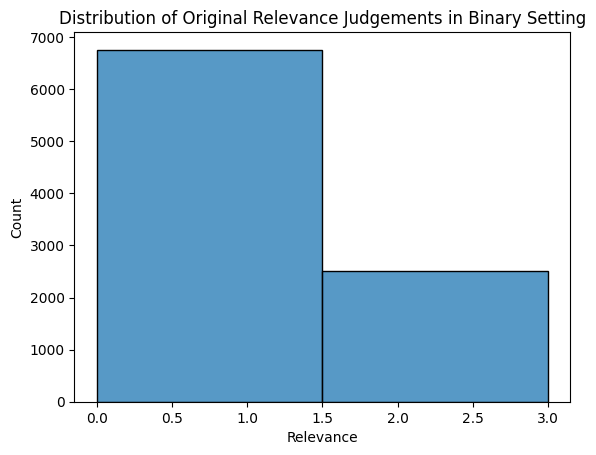

In [25]:
# sns histogram of relevance 
ax = sns.histplot(data=original_qrels_filtered, x='relevance', bins=2)
plt.title('Distribution of Original Relevance Judgements in Binary Setting')
plt.xlabel('Relevance')
plt.ylabel('Count')
plt.savefig('plots/binary_original_relevance_distribution.svg', format='svg')

9260


/tmp/ipykernel_3959/3086125011.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=tmp_all_qrels, x='relevance', palette='viridis')


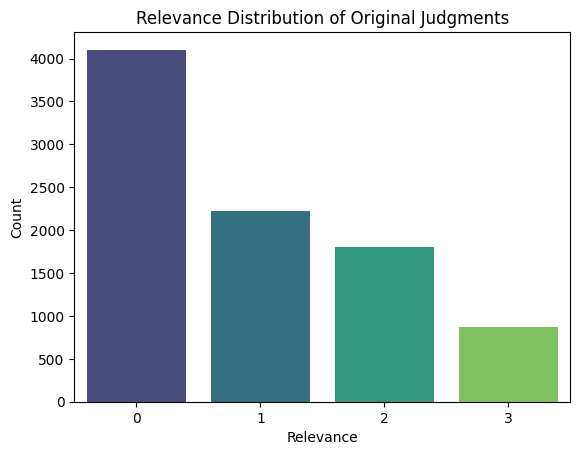

In [26]:
print(len(original_qrels_filtered))
ax = sns.countplot(data=tmp_all_qrels, x='relevance', palette='viridis')
ax.set_xlabel('Relevance')
ax.set_ylabel('Count')
ax.set_title('Relevance Distribution of Original Judgments')
plt.savefig('plots/original_relevance_distribution.svg', format='svg')

9004


/tmp/ipykernel_3959/3850809226.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=tmp_all_qrels, x='relevance', palette='viridis')


Text(0.5, 1.0, 'Relevance Distribution of New Judgments')

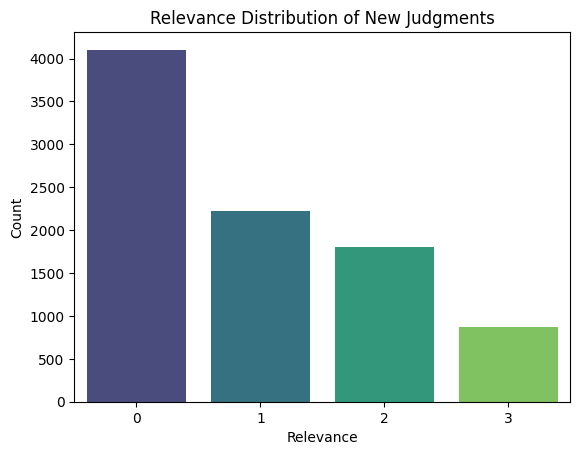

In [27]:
print(len(all_qrels))
ax = sns.countplot(data=tmp_all_qrels, x='relevance', palette='viridis')
ax.set_xlabel('Relevance')
ax.set_ylabel('Count')
ax.set_title('Relevance Distribution of New Judgments')
#plt.savefig('plots/new_relevance_distribution.svg', format='svg')

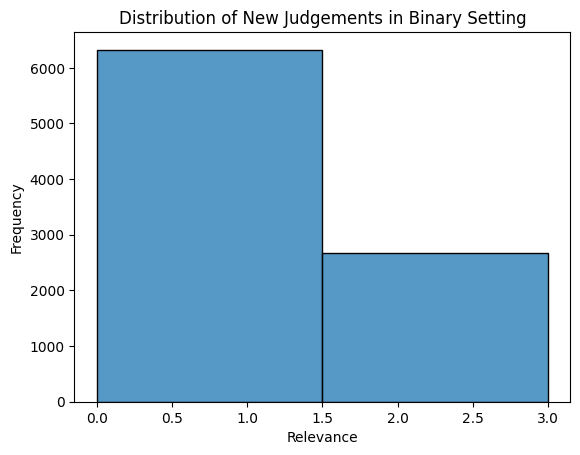

In [28]:

ax = sns.histplot(data=tmp_all_qrels, x='relevance', bins=2)
ax.set_title('Distribution of New Judgements in Binary Setting')
ax.set_xlabel('Relevance')
ax.set_ylabel('Frequency')
plt.savefig('plots/binary_new_relevance_distribution.svg', format='svg')

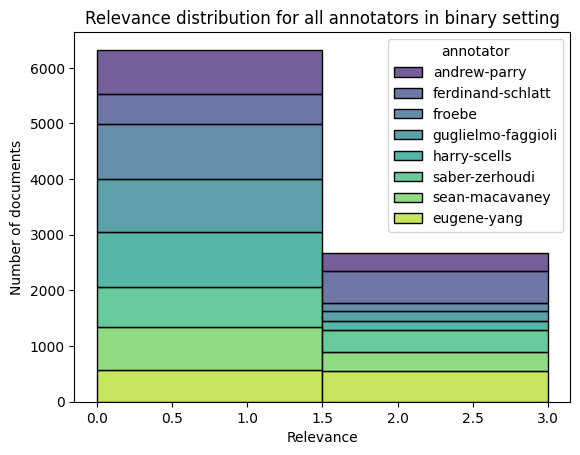

In [29]:
ax = sns.histplot(data=tmp_all_qrels, x='relevance', bins=2, hue='annotator', multiple="stack", palette='viridis')
ax.set_title('Relevance distribution for all annotators in binary setting')
ax.set_ylabel('Number of documents')
ax.set_xlabel('Relevance')
plt.savefig('plots/binary_relevance_distribution_all_annotators.svg', format='svg')

{'Annotator 1': 'Annotator 1', 'Annotator 2': 'Annotator 2', 'Annotator 3': 'Annotator 3', 'Annotator 4': 'Annotator 4', 'Annotator 5': 'Annotator 5', 'Annotator 6': 'Annotator 6', 'Annotator 7': 'Annotator 7', 'Annotator 8': 'Annotator 8'}


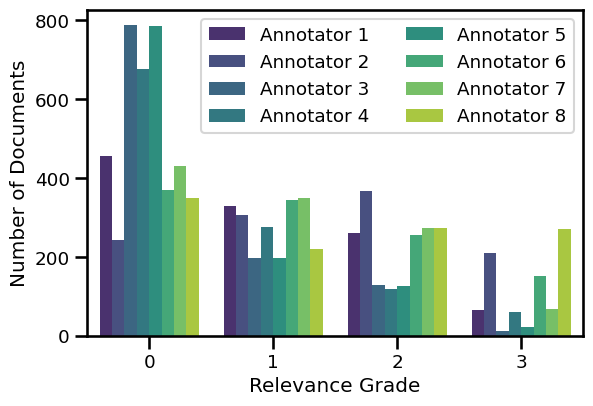

In [48]:
# barplot with exact counts 
sns.set_context("talk", font_scale=0.8)
annotator_rename = {annotator : f'Annotator {i+1}' for i, annotator in enumerate(tmp_all_qrels.annotator.unique().tolist())}
print(annotator_rename)
tmp_all_qrels['annotator'] = tmp_all_qrels['annotator'].map(annotator_rename)
ax = sns.countplot(data=tmp_all_qrels, x='relevance', hue='annotator', palette='viridis')
plt.legend(ncol=2)
ax.set_ylabel('Number of Documents')
ax.set_xlabel('Relevance Grade')
plt.subplots_adjust(bottom=0.2) 
plt.savefig('plots/relevance_distribution_all_annotators.svg', format='svg')

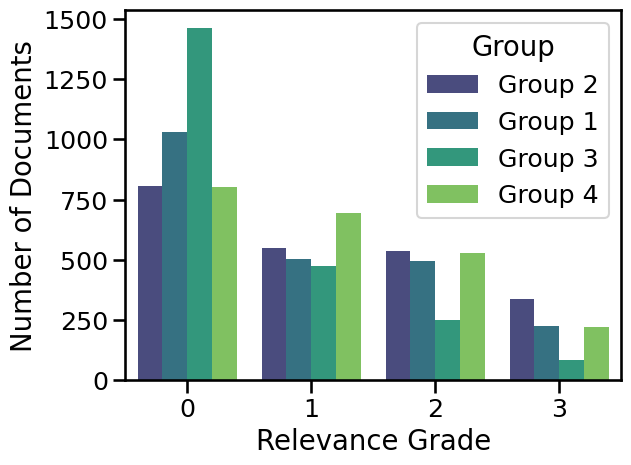

In [31]:
tmp_all_qrels['Group'] = tmp_all_qrels['group'].map(lambda x : f'Group {x}')
ax = sns.countplot(data=tmp_all_qrels, x='relevance', hue='Group', palette='viridis')
ax.set_ylabel('Number of Documents')
ax.set_xlabel('Relevance Grade')
plt.savefig('plots/relevance_distribution_all_groups.svg', format='svg')

In [32]:
original_qrels_object = TrecQrel.from_dataframe(original_qrels_filtered)

## Agreement Analysis

In [33]:
groups = []
for a, group in tmp_all_qrels.groupby('annotator'):
    new_qrels = TrecQrel.from_dataframe(group)
    groups.append(new_qrels)

(0, 0)
(0, 1)
No registers in common
(0, 2)
No registers in common
(0, 3)
No registers in common
(0, 4)
No registers in common
(0, 5)
No registers in common
(0, 6)
No registers in common
(0, 7)
(1, 0)
No registers in common
(1, 1)
(1, 2)
(1, 3)
No registers in common
(1, 4)
No registers in common
(1, 5)
No registers in common
(1, 6)
No registers in common
(1, 7)
No registers in common
(2, 0)
No registers in common
(2, 1)
(2, 2)
(2, 3)
No registers in common
(2, 4)
No registers in common
(2, 5)
No registers in common
(2, 6)
No registers in common
(2, 7)
No registers in common
(3, 0)
No registers in common
(3, 1)
No registers in common
(3, 2)
No registers in common
(3, 3)
(3, 4)
(3, 5)
No registers in common
(3, 6)
No registers in common
(3, 7)
(4, 0)
No registers in common
(4, 1)
No registers in common
(4, 2)
No registers in common
(4, 3)
(4, 4)
(4, 5)
No registers in common
(4, 6)
No registers in common
(4, 7)
(5, 0)
No registers in common
(5, 1)
No registers in common
(5, 2)
No regist

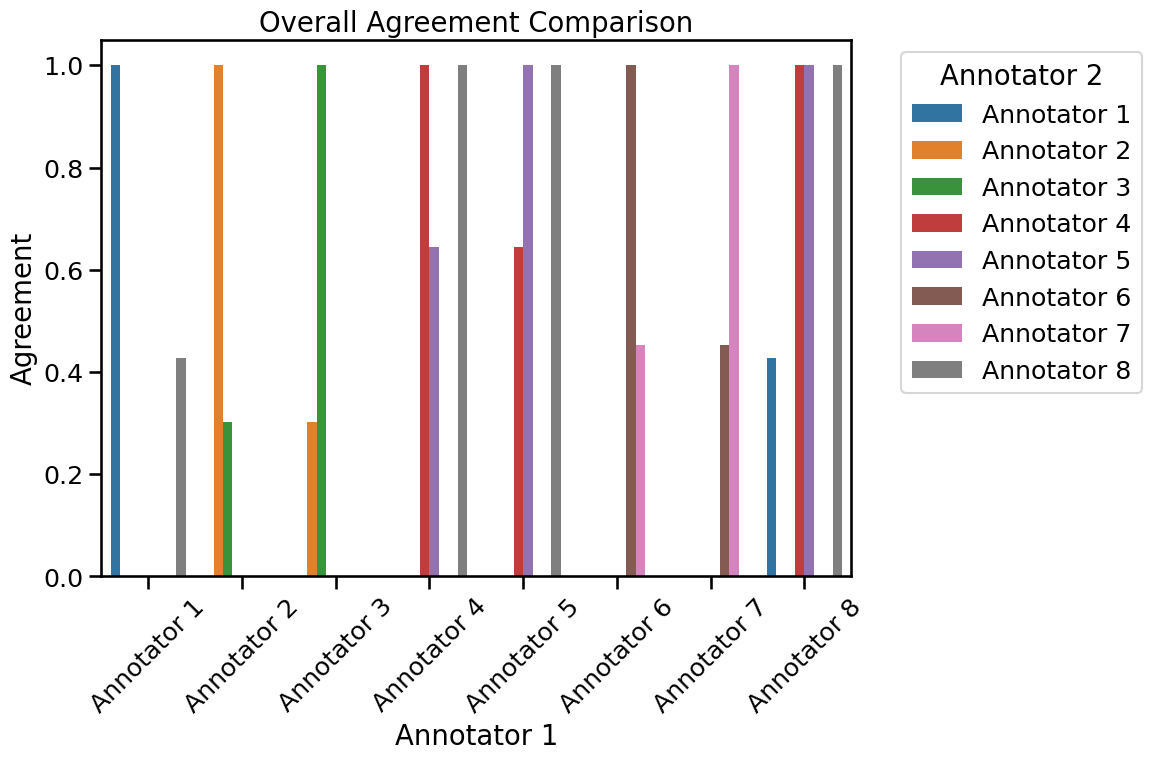

In [34]:
res = compute_qrel_comparisons(groups, tmp_all_qrels['annotator'].unique().tolist(), method='agreement')
plot_comparison_results(res, method='agreement', out='plots/agreement_all_annotators.svg')

In [35]:
binary_groups = []
for a, group in tmp_all_qrels.groupby('annotator'):
    group['relevance'] = group['relevance'].apply(lambda x: 0 if x < 2 else 1)
    new_qrels = TrecQrel.from_dataframe(group)
    binary_groups.append(new_qrels)

(0, 0)
(0, 1)
No registers in common
(0, 2)
No registers in common
(0, 3)
No registers in common
(0, 4)
No registers in common
(0, 5)
No registers in common
(0, 6)
No registers in common
(0, 7)
(1, 0)
No registers in common
(1, 1)
(1, 2)
(1, 3)
No registers in common
(1, 4)
No registers in common
(1, 5)
No registers in common
(1, 6)
No registers in common
(1, 7)
No registers in common
(2, 0)
No registers in common
(2, 1)
(2, 2)
(2, 3)
No registers in common
(2, 4)
No registers in common
(2, 5)
No registers in common
(2, 6)
No registers in common
(2, 7)
No registers in common
(3, 0)
No registers in common
(3, 1)
No registers in common
(3, 2)
No registers in common
(3, 3)
(3, 4)
(3, 5)
No registers in common
(3, 6)
No registers in common
(3, 7)
(4, 0)
No registers in common
(4, 1)
No registers in common
(4, 2)
No registers in common
(4, 3)
(4, 4)
(4, 5)
No registers in common
(4, 6)
No registers in common
(4, 7)
(5, 0)
No registers in common
(5, 1)
No registers in common
(5, 2)
No regist

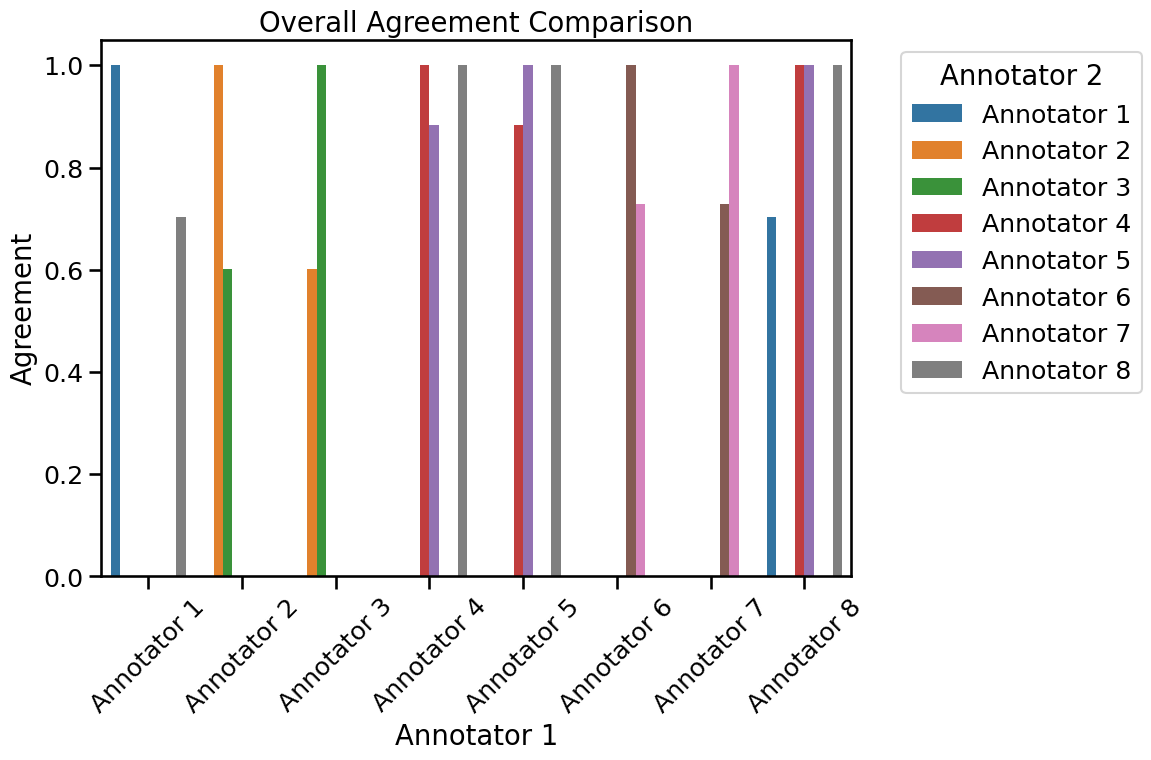

In [36]:
res = compute_qrel_comparisons(binary_groups, tmp_all_qrels['annotator'].unique().tolist(), method='agreement')
plot_comparison_results(res, method='agreement', out='plots/binary_agreement_all_annotators.svg')

## Metric Analysis

In [37]:
from ir_measures import * 
from ir_measures import evaluator
import os.path as path

In [38]:
metrics = [AP(rel=2), NDCG(cutoff=10), R(rel=2)@100, P(rel=2, cutoff=10), RR(rel=2), RR(rel=2, cutoff=10)]

#### Ingestion

In [39]:
RUN_DIR = f'{DIR}/runs/trec-dl-2019'
runs = {}
for run in os.listdir(RUN_DIR):
    frame = pt.io.read_results(path.join(RUN_DIR, run)).rename(columns={'qid': 'query_id', 'docno': 'doc_id'})
    frame['pool'] = 'dl-19-official' in run
    runs[run] = frame

### Original Qrels

In [40]:
evaluate = evaluator(metrics, original_qrels_filtered)

In [41]:
orginal_frame = []
for run_name, run in runs.items():
    results = evaluate.calc_aggregate(run)
    results = {str(k) : v for k,v in results.items()}
    results['run_name'] = run_name
    orginal_frame.append(results)
    
original_df = pd.DataFrame(orginal_frame)

KeyboardInterrupt: 

In [ ]:
original_df

# Aggregated Analysis

## max

In [ ]:
evaluate = evaluator(metrics, max_qrels)
max_frame = []
for run_name, run in runs.items():
    results = evaluate.calc_aggregate(run)
    results = {str(k) : v for k,v in results.items()}
    results['run_name'] = run_name
    max_frame.append(results)
    
max_fg = pd.DataFrame(max_frame)

In [ ]:
max_fg

## min

In [ ]:
evaluate = evaluator(metrics, min_qrels)
min_frame = []
for run_name, run in runs.items():
    results = evaluate.calc_aggregate(run)
    results = {str(k) : v for k,v in results.items()}
    results['run_name'] = run_name
    min_frame.append(results)
    
min_frame = pd.DataFrame(min_frame)

In [ ]:
min_frame

### Each Annotator

In [ ]:
each_annotator_frame = []
for annotator, qrel in all_qrels.groupby('annotator'):
    evaluate = evaluator(metrics, qrel.copy())
    for run_name, run in runs.items():
        results = evaluate.calc_aggregate(run)
        results = {str(k) : v for k,v in results.items()}
        results['run_name'] = run_name
        results['annotator'] = annotator
        each_annotator_frame.append(results)

each_annotator_df = pd.DataFrame(each_annotator_frame)

In [ ]:
# facetplot over runs, with bars for each metric
_each_annotator_df = each_annotator_df[each_annotator_df['annotator'] != 'ground-truth']
#g = sns.FacetGrid(_each_annotator_df, col='run_name', col_wrap=3, sharey=True, height=4, aspect=2)
# set fig size 
plt.figure(figsize=(12, 8))
g = sns.barplot(_each_annotator_df, x='annotator', y='nDCG@10', hue='run_name', palette='viridis', errwidth=0)
plt.xlabel('Annotator')
plt.ylabel('nDCG@10')
plt.legend(loc='upper right')
plt.savefig('plots/ndcg10_each_annotator.svg', format='svg')

# Per-Query Analysis

## Original

In [ ]:
evaluate = evaluator(metrics, original_qrels_filtered)

In [ ]:
orginal_frame = []
for run_name, run in runs.items():
    for metric in evaluate.iter_calc(run):
        result = {'query_id' : metric.query_id, 'run_name' : run_name, 'metric' : str(metric.measure), 'value' : metric.value}
        orginal_frame.append(result)
original_df = pd.DataFrame(orginal_frame)

## Each Annotator

In [ ]:
each_annotator_frame = []
for annotator, qrel in all_qrels.groupby('annotator'):
    evaluate = evaluator(metrics, qrel.copy())
    for run_name, run in runs.items():
        for metric in evaluate.iter_calc(run):
            result = {'query_id' : metric.query_id, 'run_name' : run_name, 'metric' : str(metric.measure), 'value' : metric.value, 'annotator' : annotator}
            each_annotator_frame.append(result)

each_annotator_df = pd.DataFrame(each_annotator_frame)

## Accumulated Annotators

In [ ]:
evaluate = evaluator(metrics, accumulated_qrels)

accumulated_frame = []

for run_name, run in runs.items():
    for metric in evaluate.iter_calc(run):
        result = {'query_id' : metric.query_id, 'run_name' : run_name, 'metric' : str(metric.measure), 'value' : metric.value}
        accumulated_frame.append(result)

accumulated_df = pd.DataFrame(accumulated_frame)

In [ ]:
each_annotator_df.query_id.unique()

In [ ]:
# filter to nDCG@10

original_ndcg = original_df[original_df['metric'] == 'nDCG@10']
each_annotator_ndcg = each_annotator_df[each_annotator_df['metric'] == 'nDCG@10']

In [ ]:
# merge with original ndcg

each_annotator_ndcg = each_annotator_ndcg.merge(original_ndcg, on=['query_id', 'run_name'], suffixes=('_annotator', '_original'))

In [ ]:
each_annotator_ndcg.query_id.unique()

In [ ]:
each_annotator_ndcg

In [ ]:
# scatter plot of nDCG@10 for each annotator vs original
_each_annotator_ndcg = each_annotator_ndcg[each_annotator_ndcg.annotator != 'ground-truth'].copy()
ax = sns.scatterplot(data=_each_annotator_ndcg, x='value_original', y='value_annotator', hue='annotator', palette='viridis')
# add line of best fit
sns.regplot(data=_each_annotator_ndcg, x='value_original', y='value_annotator', scatter=False)
ax.set(xlim=(-0.2, 1.2))
ax.set(ylim=(-0.2, 1.2))
ax.set_title('nDCG@10 for each annotator vs original')
ax.set_xlabel('Original nDCG@10')
ax.set_ylabel('Annotator nDCG@10')
plt.savefig('plots/ndcg10_each_annotator_vs_original.svg', format='svg')

In [ ]:
# facets over runs with scatter plot of nDCG@10 for each annotator vs original, increase spacing

g = sns.FacetGrid(_each_annotator_ndcg, col='run_name', col_wrap=3, height=4, aspect=1.5)
g.map(sns.scatterplot, 'value_original', 'value_annotator', 'annotator', palette='viridis')
# add line of best fit
g.map(sns.regplot, 'value_original', 'value_annotator', scatter=False)
# set x range to be the same for all plots
g.set(xlim=(-0.2, 1.2))
g.set(ylim=(-0.2, 1.2))
g.set_titles('nDCG@10 for each annotator vs original for {col_name}')
g.set_xlabels('Original nDCG@10')
g.set_ylabels('Annotator nDCG@10')
g.add_legend()
plt.savefig('plots/ndcg10_each_annotator_vs_original_facets.svg', format='svg')

In [ ]:
each_annotator_ndcg[each_annotator_ndcg['value'] == 0.]

In [ ]:
# bar plot of per query nDCG@10 variance over annotators
each_annotator_ndcg = each_annotator_df[each_annotator_df['metric'] == 'nDCG@10'].copy()
each_annotator_ndcg['variance'] = each_annotator_ndcg.groupby(['query_id', 'run_name'])['value'].transform('var')
ax = sns.barplot(data=each_annotator_ndcg, x='query_id', y='variance', hue='run_name', palette='viridis')
ax.set_title('Per query nDCG@10 variance over annotators')
ax.set_xlabel('Query ID')
ax.set_ylabel('Variance')
# rotate x labels
plt.xticks(rotation=45)
plt.savefig('plots/ndcg10_variance_over_annotators.svg', format='svg')

In [ ]:
for qid in each_annotator_ndcg.query_id.unique():
    print(qid)
    print(query_lookup[int(qid)])